# NYU - CUSP UDP Capstone
# Topologies Master 
## Brief
This notebook 
- imports the shapefile
- imports topologies results
- merges shapefiles with topologies
- map topologies
- outputs a .csv of the results


In [32]:
#! pip install geopandas
#import all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
%pylab inline

# To ignore some warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import requests
import shapely
import json
from fiona.crs import from_epsg
import scipy as sp
from scipy import stats
import geopy.distance
#from getCitiBikeCSV import getCitiBikeCSV # must have this function locally or in path
#pd.options.display.max_columns = None
DEVELOPING = False
#from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path
#from evalChisq import evalChisqgeoid

from urllib.error import HTTPError
import urllib.request as request
try:
    from urllib import urlretrieve as urlretrieve
except ImportError:
    from urllib.request import urlretrieve as urlretrieve

Populating the interactive namespace from numpy and matplotlib


In [33]:
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas import GeoDataFrame
from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [34]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))

Master: /nfshome/mv1742/Capstone/udpny_2


In [35]:
def getGeoDataFrameFromShpFileZipUrl(url):
    '''
    This function downloads the zip file, unzips it into the dorectory 
    pointed to by PUIdata environment variable. Then it 
    reads it into a gepandas dataframe
    '''
    
    folderName = 'shape'+ \
        str(len(os.listdir(os.getenv('TaxiData')))+1)
    os.makedirs(os.getenv('Master') + '/' + folderName)
    urlretrieve(url, "region.zip")
    os.system('unzip -d $Master'+'/'+folderName+' region.zip')
    filenames = [f for f in os.listdir(os.getenv('Master') + '/' + folderName) if f.endswith('.shp') ]
    shapeFile = filenames[0]
    shapeFilePath = os.getenv('Master') + '/' + folderName + '/' + shapeFile
    return gpd.GeoDataFrame.from_file(shapeFilePath)

# Import Shape Files
#### Retrieved from latest Census 2016 results from NYC Planning Metro Region Explorer:
https://metroexplorer.planning.nyc.gov/about

and four missing census tracts from census.gov American Fact Finder: https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml


In [71]:
# url = 'https://planninglabs.carto.com/api/v2/sql?filename=region&q=SELECT%20%2A%20FROM%20region_censustract_v0&format=SHP'
# NYCzip = getGeoDataFrameFromShpFileZipUrl(url)
NYCzip=gpd.read_file('Censustracts/region.shp')

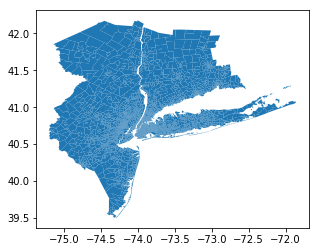

In [72]:
NYCzip.plot()

In [73]:
NYCzip.columns

Index(['aland_mi', 'objectid', 'statefp', 'countyfp', 'tractce', 'geoid',
       'name', 'namelsad', 'mtfcc', 'funcstat', 'aland', 'awater', 'intptlat',
       'intptlon', 'shape_leng', 'shape_area', 'atotal', 'atotal_mi',
       'cartodb_id', 'geoid_1', 'hou16', 'hou16moe', 'hou16cv', 'houv16',
       'houv16moe', 'houv16cv', 'houo16', 'houo16moe', 'houo16cv', 'hour16',
       'hour16moe', 'hour16cv', 'emtot15', 'empr15', 'emoff15', 'emins15',
       'emind15', 'emser15', 'emoth15', 'geometry'],
      dtype='object')

In [74]:
NYCzip

,aland_mi,objectid,statefp,countyfp,tractce,geoid,name,namelsad,mtfcc,funcstat,...,hour16moe,hour16cv,emtot15,empr15,emoff15,emins15,emind15,emser15,emoth15,geometry
0,10.14335,17,34,013,021601,34013021601,216.01,Census Tract 216.01,G5020,S,...,109.0,25.583551,22750.0,22492.0,7641.0,1229.0,10729.0,2162.0,731.0,"POLYGON ((-74.3228040001045 40.90883400018899,..."
1,3.16034,27,34,003,031100,34003031100,311,Census Tract 311,G5020,S,...,214.0,10.602379,8274.0,8172.0,3602.0,219.0,3181.0,1084.0,86.0,POLYGON ((-74.08304199968846 40.78623200040653...
2,1.84139,50,34,003,036200,34003036200,362,Census Tract 362,G5020,S,...,75.0,19.156599,8825.0,8224.0,1252.0,217.0,5718.0,975.0,62.0,POLYGON ((-74.03536299980257 40.82861799992076...
3,0.03451,95,34,017,003500,34017003500,35,Census Tract 35,G5020,S,...,67.0,6.133958,58.0,58.0,33.0,7.0,4.0,14.0,0.0,POLYGON ((-74.04668899959766 40.72066899957468...
4,0.11672,108,34,017,015500,34017015500,155,Census Tract 155,G5020,S,...,137.0,6.123726,676.0,620.0,82.0,106.0,84.0,321.0,27.0,POLYGON ((-74.01458600034361 40.79119299985706...
5,0.12662,130,34,013,013200,34013013200,132,Census Tract 132,G5020,S,...,127.0,11.804839,93.0,93.0,11.0,2.0,6.0,65.0,9.0,POLYGON ((-74.21338700040968 40.73388700028482...
6,3.58591,203,34,027,044501,34027044501,445.01,Census Tract 445.01,G5020,S,...,147.0,12.693424,3505.0,3185.0,683.0,48.0,195.0,2134.0,125.0,(POLYGON ((-74.56219999983014 40.9012120003335...
7,1.32701,209,34,023,004500,34023004500,45,Census Tract 45,G5020,S,...,144.0,4.937281,718.0,718.0,171.0,2.0,492.0,41.0,12.0,(POLYGON ((-74.25451090392684 40.5403372012258...
8,1.36273,225,34,003,007001,34003007001,70.01,Census Tract 70.01,G5020,S,...,81.0,16.468268,1115.0,1114.0,194.0,292.0,376.0,206.0,46.0,POLYGON ((-73.96304000019583 40.98273799985878...
9,0.31952,237,34,003,019102,34003019102,191.02,Census Tract 191.02,G5020,S,...,88.0,7.471430,1707.0,1549.0,706.0,478.0,212.0,118.0,35.0,"POLYGON ((-73.95468099962847 40.8616329998631,..."


In [75]:
NYCzip.rename(columns={"geoid": "GEOID"},inplace=True)
NYCzip.GEOID = NYCzip.GEOID.astype(int)
cols = ['GEOID','geometry']
NYCzip = NYCzip.loc[:,cols]
#NYCzipgdp.plot(column='GEOID',legend = True)
NYCzip.shape

(5294, 2)

In [76]:
NYCzip.isnull().sum()

GEOID       0
geometry    0
dtype: int64

In [77]:
# NYCzipgdp.dropna(inplace=True)
NYCzip.shape

(5294, 2)

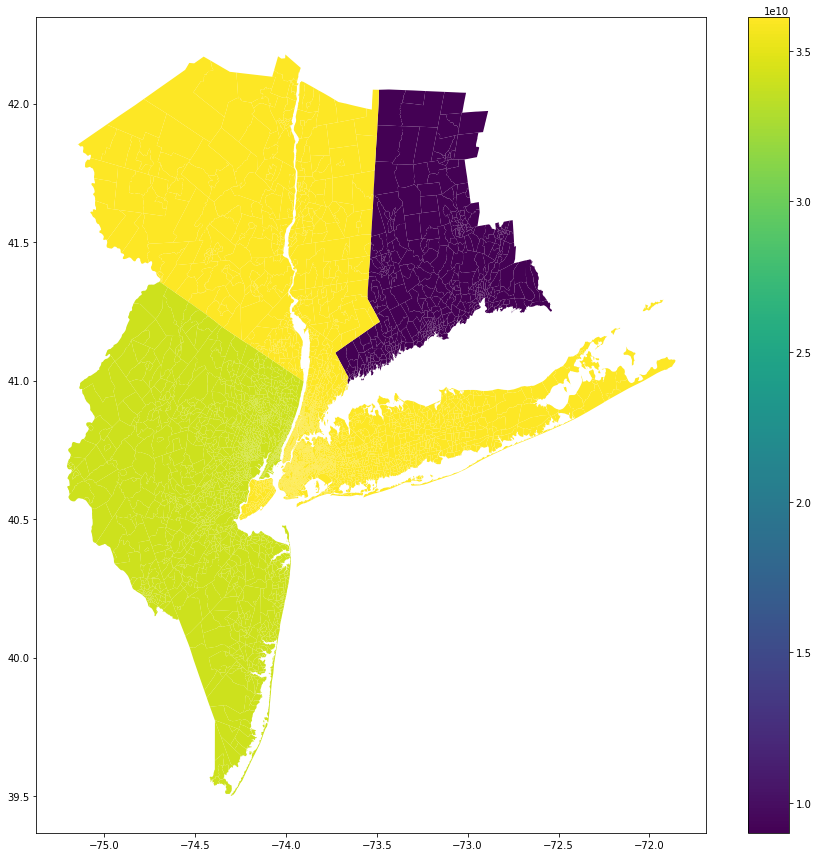

In [78]:
figure, ax = plt.subplots(figsize=(15, 15))
NYCzip.plot(column='GEOID',legend = True, ax=ax)

In [79]:
(NYCzip.GEOID == 34005701502).sum()

0

In [81]:
others_zip = gpd.read_file('Censustracts/reference_map_shape/14000.shp')
# i 34005701502
# i 34005701700
# i 34005981802
# i 36085990100
others_zip

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,SHAPE_AREA,SHAPE_LEN,geometry
0,1400000US34005981802,34,005,981802,9818.02,Tract,4.441712e+06,10337.630444,"POLYGON ((-8313617.3146 4888372.220200002, -83..."
1,1400000US34005701502,34,005,701502,7015.02,Tract,1.197197e+07,19772.462733,"POLYGON ((-8316997.0856 4891391.936499998, -83..."
2,1400000US34005701700,34,005,701700,7017,Tract,4.314335e+06,9303.626332,"POLYGON ((-8317731.9056 4887429.785599999, -83..."
3,1400000US36085990100,36,085,990100,9901,Tract,1.390466e+08,72313.254697,POLYGON ((-8266483.974300001 4938804.908699997...


In [82]:
others_zip.rename(columns={"GEO_ID": "GEOID"},inplace=True)
print(type(others_zip.GEOID[0]))
others_zip.GEOID = others_zip.GEOID.str[-11:]
others_zip


<class 'str'>


,GEOID,STATE,COUNTY,TRACT,NAME,LSAD,SHAPE_AREA,SHAPE_LEN,geometry
0,34005981802,34,005,981802,9818.02,Tract,4.441712e+06,10337.630444,"POLYGON ((-8313617.3146 4888372.220200002, -83..."
1,34005701502,34,005,701502,7015.02,Tract,1.197197e+07,19772.462733,"POLYGON ((-8316997.0856 4891391.936499998, -83..."
2,34005701700,34,005,701700,7017,Tract,4.314335e+06,9303.626332,"POLYGON ((-8317731.9056 4887429.785599999, -83..."
3,36085990100,36,085,990100,9901,Tract,1.390466e+08,72313.254697,POLYGON ((-8266483.974300001 4938804.908699997...


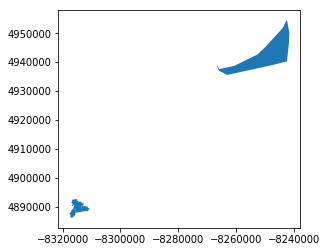

In [83]:
others_zip.plot()

In [84]:
others_zip.GEOID = others_zip.GEOID.astype(int)
cols = ['GEOID','geometry']
others_zip = others_zip.loc[:,cols]

In [85]:
print(others_zip.crs)
others_zip.to_crs(epsg=4326, inplace = True)


{'init': 'epsg:3857'}


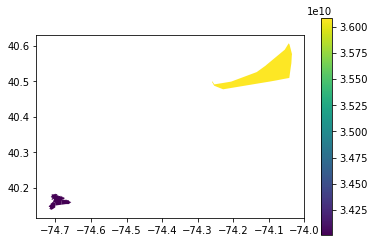

In [86]:
others_zip.plot(column='GEOID',legend = True)

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:4326'} {'init': 'epsg:4326', 'no_defs': True}


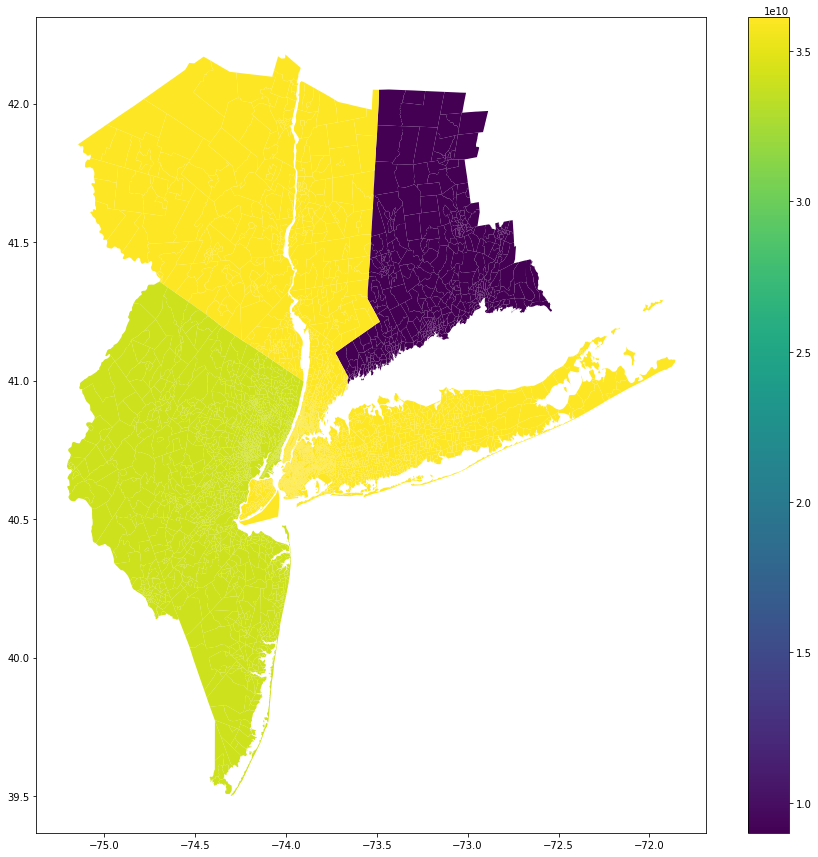

In [89]:
figure, ax = plt.subplots(figsize=    (15, 15))
NYCzip_other = NYCzip.append(others_zip)
print(type(NYCzip))
print(type(others_zip))
print(NYCzip.crs,others_zip.crs)
# NYCzip_other = gpd.GeoDataFrame(NYCzip_other)
# NYCzip_other.shape
NYCzip_other.reset_index(inplace = True)            
NYCzip_other.plot(column='GEOID',legend = True, ax=ax)

In [90]:
(NYCzip_other.GEOID == 34005701502).sum()
NYCzip_other = NYCzip_other.drop('index',axis =1)

# Import Latest Typologies (Jan 2019)
#### Retrieved from latest results from Jan 19. Provided by Dr. Karen Chapple by email on April 12th 2019.

In [91]:
Typologiespd=pd.read_csv('NY_final_data_for_typologies_1.19.19.csv')
Typologiesgdp = gpd.GeoDataFrame(Typologiespd)
Typologiesgdp.columns

Index(['geoid', 'typology_old', 'medrent90', 'medrent00', 'medrent16',
       'medhval90', 'medhval00', 'medhval16', 'percol90', 'percol00',
       'percol16', 'pernwh90', 'pernwh00', 'pernwh16', 'perli90', 'perli00',
       'perli16', 'per_rent_90', 'per_rent_00', 'per_rent16', 'pop00', 'pop16',
       'asian_16_low', 'carcommuters_00', 'pre50_16', 'hhwch16', 'empd15',
       'density16', 'aland', 'li16', 'afford90', 'belowmedcol90',
       'abovemednwh', 'abovemedli', 'abovemedrent', 'vulnrisk90', 'vuln90',
       'afford00', 'belowmedcol00', 'abovemednwh00', 'abovemedli00',
       'abovemedrent00', 'vulnrisk00', 'vuln00', 'afford16', 'belowmedcol16',
       'abovemednwh16', 'abovemedli16', 'abovemedrent16', 'vulnrisk16',
       'vuln16', 'hotmarket90(127%-169%)', 'hotmarket00(110%-207%)',
       'percol16.1', 'edudiff0016', 'abm_dif_0016', 'edudiff9000',
       'abm_dif_9000', 'hinc90_NYU', 'hinc00_NYU', 'hinc16_NYU', 'hinc90',
       'hinc00', 'hinc16', 'pct_ch_hinc90_00', 'pct_ch_

In [92]:
Typologiesgdp.rename(columns={'geoid': "GEOID"},inplace=True)
Typologiesgdp.tail()

,GEOID,typology_old,medrent90,medrent00,medrent16,medhval90,medhval00,medhval16,percol90,percol00,...,ch_all_li_count90_00,ch_all_li_count00_16,liloss9016,per_limove16,per_limove09,exclusion,popgrowth0016,Incch0016,li_hh_16,Typology_final_1.19.19
5293,3.611998e+10,Missing Data,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,...,#NULL!,0.7217962742,#NULL!,#NULL!,#NULL!,1,NaN,#DIV/0!,0.0,VHI - Super Gentrification or Exclusion
5294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5296,NaN,NaN,623.0,793.0,1342.0,175600.0,192800.0,400000.0,0.18229,0.163948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5297,NaN,NaN,498.4,634.4,1073.6,140480.0,154240.0,320000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
cols_typ = ['GEOID','Type_1.19']
print(type(Typologiesgdp.iloc[:,0][0]))
#Typologies.rename(columns={'\ufeffgeoid': "GEOID"},inplace=True)
#Typologiesgdp.geoid = Typologies.iloc[:,0]
Typologiesgdp = Typologiesgdp.loc[:,cols_typ]
Typologiesgdp.head()

<class 'numpy.float64'>


,GEOID,Type_1.19
0,9.001010e+09,VHI - Super Gentrification or Exclusion
1,9.001010e+09,VHI - Super Gentrification or Exclusion
2,9.001010e+09,VHI - Super Gentrification or Exclusion
3,9.001010e+09,VHI - Super Gentrification or Exclusion
4,9.001010e+09,VHI - Super Gentrification or Exclusion


In [94]:
Typologiesgdp.shape

(5298, 2)

In [95]:
Typologiesgdp.dropna(inplace=True)
Typologiesgdp.GEOID = Typologiesgdp.GEOID.astype(int)

## Clean Data

## Clean Typologies

In [96]:
#NYCzipgdp.isnull().sum()
Typologiesgdp.isin([0]).sum()

GEOID        0
Type_1.19    0
dtype: int64

In [97]:
Typologiesgdp.isnull().sum()

GEOID        0
Type_1.19    0
dtype: int64

In [98]:
print(len(Typologiesgdp.GEOID.unique()))
Typologiesgdp.dropna(inplace=True)
Typologiesgdp.shape

5294


(5294, 2)

In [99]:
Typologiesgdp =Typologiesgdp.drop_duplicates()
Typologiesgdp.shape

(5294, 2)

In [100]:
# print(NYCzipgdp.shape)
Typologiespd.rename(columns={'geoid': "GEOID"},inplace=True)
Typologiespd[Typologiespd.GEOID==36047021000]

,GEOID,typology_old,medrent90,medrent00,medrent16,medhval90,medhval00,medhval16,percol90,percol00,...,ch_all_li_count90_00,ch_all_li_count00_16,liloss9016,per_limove16,per_limove09,exclusion,popgrowth0016,Incch0016,li_hh_16,Typology_final_1.19.19
2574,3.604702e+10,LI - At Risk of Gentrification,510.0,719.0,1294.0,180600.0,304000.0,753600.0,0.153772,0.111511,...,-34.61495972,193.6968689,0,0.6530608535,0.4945183396,0,1.0,0.9431680524,671.86725,MHI - Ongoing Exclusion


In [101]:
Typologiesgdp.tail()

,GEOID,Type_1.19
5289,36119981000,MHI - Stable or Early Stage of Exclusion
5290,36119982000,Missing Data
5291,36119983000,MHI - Stable or Early Stage of Exclusion
5292,36119984000,Missing Data
5293,36119985000,Missing Data


### MERGE

In [102]:
merged = NYCzip.merge(Typologiesgdp,on='GEOID')
merged.tail()

,GEOID,geometry,Type_1.19
5285,36061021703,POLYGON ((-73.94607800039937 40.82126399983373...,Missing Data
5286,36061021800,POLYGON ((-73.94872800029694 40.80333100022552...,LI - Ongoing Gentrification
5287,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",LI - Ongoing Displacement of Low-Income Househ...
5288,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,LI - Ongoing Gentrification
5289,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",MHI - Stable or Early Stage of Exclusion


In [103]:
print(type(merged),merged.shape)
mergedgpd = gpd.GeoDataFrame(merged)
mergedgpd.shape

<class 'geopandas.geodataframe.GeoDataFrame'> (5290, 3)


(5290, 3)

In [104]:
mergedgpd.isnull().sum()

GEOID        0
geometry     0
Type_1.19    0
dtype: int64

In [105]:
print(len(Typologiesgdp.GEOID),len(mergedgpd.GEOID))
print(type(Typologiesgdp.GEOID),type(mergedgpd.GEOID))
 

5294 5290
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [106]:
excluded = []
for i in Typologiesgdp.GEOID:
    if i not in list(mergedgpd.GEOID):
        print('i',i)
        excluded.append(i)
excluded

i 34005701502
i 34005701700
i 34005981802
i 36085990100


[34005701502, 34005701700, 34005981802, 36085990100]

In [107]:
(NYCzip.GEOID == 36061022102).sum()

1

In [108]:
# mergedgpd.crs = from_epsg(4326)
# mergedgpd.crs

In [109]:
# mergedgpd.to_crs(epsg=2263, inplace = True)
# mergedgpd.crs

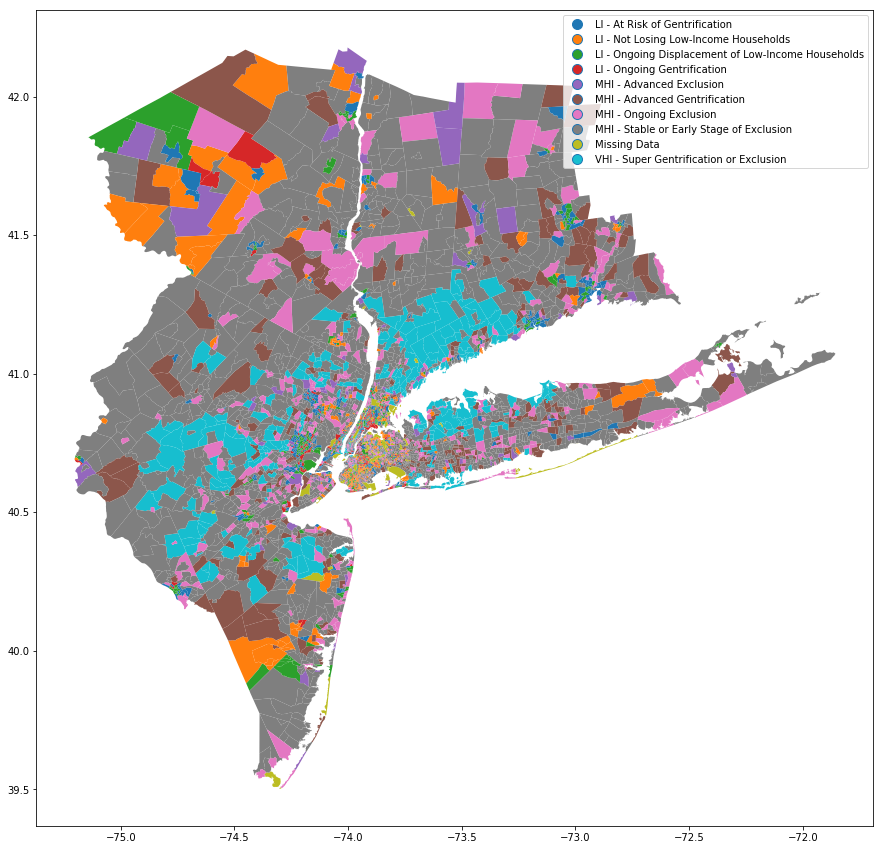

In [110]:
figure, ax = plt.subplots(figsize=(15, 15))
mergedgpd.plot(column='Type_1.19',legend = True, ax=ax)

In [2]:
# mergedgpd.to_csv('UDPNY_shapefilesTypology_final_1.19.19.csv')

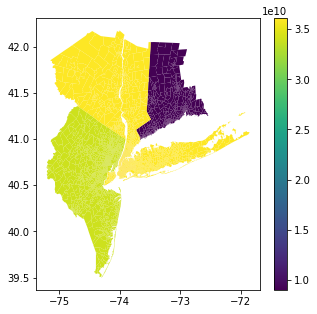

In [112]:
figure, ax = plt.subplots(figsize=(5, 5))
mergedgpd.plot(column='GEOID',legend = True, ax=ax)

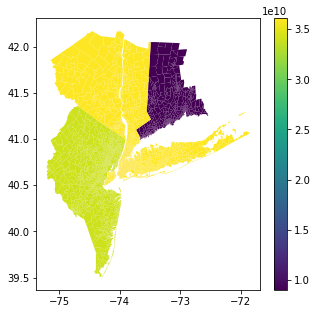

In [117]:
figure, ax = plt.subplots(figsize=(5, 5))
NYCzip.plot(column='GEOID',legend = True, ax=ax)